## 1. Se cargan librerías a utilizar

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (8, 8)
import seaborn as sns
from IPython.core.pylabtools import figsize

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn import preprocessing

# Models
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# Cross-validation
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

np.random.seed(42)

## 2. Carga de datos y manipulación de algunas columnas

In [2]:
link = 'data_desafio_seguros.txt'

In [3]:
df = pd.read_csv(link, delimiter=",")

In [4]:
col_actuales = df.columns
col_nuevas = []
for col in col_actuales:
    if col == 'row_id':
        col_nuevas.append('row_id')
    elif col == '20':
        col_nuevas.append('Clasificación')
    else:
        col_nuevas.append('Atributo' + str(int(col)+1))

In [5]:
df.columns = col_nuevas
df.drop('row_id', axis=1, inplace=True)
df['Clasificación'].replace([1,2], [0,1], inplace=True)

In [6]:
df.head()

,Atributo1,Atributo2,Atributo3,Atributo4,Atributo5,Atributo6,Atributo7,Atributo8,Atributo9,Atributo10,...,Atributo12,Atributo13,Atributo14,Atributo15,Atributo16,Atributo17,Atributo18,Atributo19,Atributo20,Clasificación
0,A12,30,A34,A40,4249,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,1
1,A14,36,A32,A43,3835,A65,A75,2,A92,A101,...,A121,45,A143,A152,1,A172,1,A192,A201,0
2,A12,12,A34,A41,1804,A62,A72,3,A93,A101,...,A122,44,A143,A152,1,A173,1,A191,A201,0
3,A13,12,A31,A49,609,A61,A72,4,A92,A101,...,A121,26,A143,A152,1,A171,1,A191,A201,1
4,A12,21,A32,A49,2767,A62,A75,4,A91,A101,...,A123,61,A141,A151,2,A172,1,A191,A201,1


### 2.1. Se observa una gran cantidad de atributos categóricos, por lo que se procederá a llevarlos a atributos "one-hot-encoder", donde se representa con un 1 o un 0 si el par atributo-categoría está presente.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 21 columns):
Atributo1        900 non-null object
Atributo2        900 non-null int64
Atributo3        900 non-null object
Atributo4        900 non-null object
Atributo5        900 non-null int64
Atributo6        900 non-null object
Atributo7        900 non-null object
Atributo8        900 non-null int64
Atributo9        900 non-null object
Atributo10       900 non-null object
Atributo11       900 non-null int64
Atributo12       900 non-null object
Atributo13       900 non-null int64
Atributo14       900 non-null object
Atributo15       900 non-null object
Atributo16       900 non-null int64
Atributo17       900 non-null object
Atributo18       900 non-null int64
Atributo19       900 non-null object
Atributo20       900 non-null object
Clasificación    900 non-null int64
dtypes: int64(8), object(13)
memory usage: 147.7+ KB


In [8]:
aux_df = df.select_dtypes(include='object')
one_hot_col = aux_df.columns
one_hot_col

Index(['Atributo1', 'Atributo3', 'Atributo4', 'Atributo6', 'Atributo7',
       'Atributo9', 'Atributo10', 'Atributo12', 'Atributo14', 'Atributo15',
       'Atributo17', 'Atributo19', 'Atributo20'],
      dtype='object')

In [9]:
df_one_hot_encoder = df.copy()
df_one_hot_encoder = pd.get_dummies(df_one_hot_encoder, columns = one_hot_col, prefix='')

In [10]:
df_one_hot_encoder.head()

,Atributo2,Atributo5,Atributo8,Atributo11,Atributo13,Atributo16,Atributo18,Clasificación,_A11,_A12,...,_A152,_A153,_A171,_A172,_A173,_A174,_A191,_A192,_A201,_A202
0,30,4249,4,2,28,2,1,1,0,1,...,1,0,0,0,0,1,1,0,1,0
1,36,3835,2,4,45,1,1,0,0,0,...,1,0,0,1,0,0,0,1,1,0
2,12,1804,3,4,44,1,1,0,0,1,...,1,0,0,0,1,0,1,0,1,0
3,12,609,4,1,26,1,1,1,0,0,...,1,0,1,0,0,0,1,0,1,0
4,21,2767,4,2,61,2,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0


### 2.2. Separamos nuestro dataframe en atributos y clase a predecir. Haremos predicciones sobre la probabilidad de que un cliente caiga en mora. El resultado de la predicción será el score de riesgo.

In [11]:
Y = df_one_hot_encoder['Clasificación']
df_X = df_one_hot_encoder.drop('Clasificación', axis=1)

In [12]:
print('Shape of Y: ', Y.shape)
print('Shape of df_X: ', df_X.shape)

Shape of Y:  (900,)
Shape of df_X:  (900, 61)


## 3. Se procede a estandarizar la data con el fin de escalar la varianza entre atributos con distintas magnitudes, cómo por ejemplo el atributo 5 vs los demás.

In [13]:
scaler = preprocessing.StandardScaler().fit(df_X)
X = scaler.transform(df_X)

c:\python\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\python\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


## 4. Se contruye una función para evaluar los distintos clasificadores a utilizar.
### Los algoritmos son los siguientes: LogisticRegression, DecisionTreeClassifier, SVM, KNN, GradientBoostingClassifier, RandomForestClassifier.
### Se calculan métricas (precision y recall) para distintos thresholds, con la finalidad de elegir un valor que maximice el recall. Esto con el fin de cumplir la regla de negocio “Es 5 veces peor clasificar un cliente como bueno cuando es malo, que malo cuando es bueno"
### No se indagó demasiado sobre los hiper-parámetros de cada algoritmo y en su gran mayoría se usaron los valores por defecto.

In [14]:
def evaluar_modelo(X, Y, modelo=None, test_size=0.2, cv = 6, class_weight = {0:0.3, 1:0.7}):
    
    np.random.seed(42)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    
    if modelo == None:
        print("No elegiste modelo")
    elif modelo == "LogisticRegression":
        clf = linear_model.LogisticRegression(solver = 'liblinear', class_weight=class_weight)
    elif modelo == "DecisionTreeClassifier":
        clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=10, class_weight=class_weight)
    elif modelo == "SVM":
        clf = svm.SVC(random_state=42, probability=True, gamma='scale', class_weight=class_weight, C=1)
    elif modelo == "KNN":
        clf = KNeighborsClassifier(n_neighbors=18)
    elif modelo == "GradientBoostingClassifier":
        clf = GradientBoostingClassifier(random_state=42, n_estimators=1000, learning_rate=0.01, min_samples_leaf=10)
    elif modelo == "RandomForestClassifier":
        clf = RandomForestClassifier(random_state=42, n_estimators=1000, min_samples_leaf=10, class_weight=class_weight)
    else:
        print("Modelo no implementado")
        
    model = clf.fit(X_train, y_train)
    
    cross_validation_score = cross_val_score(clf, X_test, y_test, cv = cv)
    print("Cross validation scores: ", cross_validation_score)
    print("Cross validation average score: ", np.average(cross_validation_score))
    
    y_pred = model.predict_proba(X_test)[:,1]
    
    thresholds = np.arange(0.2,0.85,0.05)
    results = pd.DataFrame(columns=['threshold', 'accuracy', 'precision', 'recall'], index=thresholds)
    
    for k in thresholds:
        y_pred_conf = [1 if x > k else 0 for x in y_pred]
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_conf, labels=[0, 1]).ravel()
        accuracy = (tp + tn)/(tp + fp + fn + tn)
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        
        results.loc[k,:]= [k, accuracy, precision, recall]
        
#     print(results)
    fig = plt.figure()
    plt.plot(results['threshold'], results['accuracy'], 'green', label = "Accuracy")
    plt.plot(results['threshold'], results['precision'], 'blue', label = 'Precision')
    plt.plot(results['threshold'], results['recall'], 'red', label = 'Recall')
    plt.xlim(0.2,0.8)
    plt.ylim(0.4,1)
    plt.xlabel('threshold')
    plt.ylabel('Porcentaje')
    plt.legend()

## 5. Resultados

## 5.1. Regresión logística

Cross validation scores:  [0.80645161 0.67741935 0.8        0.63333333 0.75862069 0.75862069]
Cross validation average score:  0.739074280064269


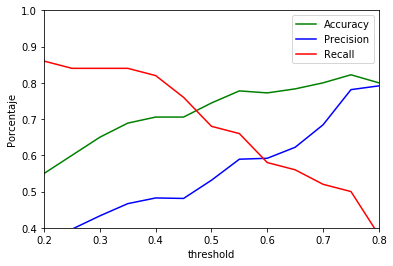

In [15]:
evaluar_modelo(X, Y, "LogisticRegression")

## 5.2. Árbol de decisiones

Cross validation scores:  [0.67741935 0.67741935 0.66666667 0.7        0.68965517 0.72413793]
Cross validation average score:  0.689216413298727


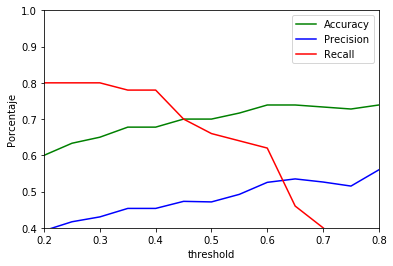

In [16]:
evaluar_modelo(X, Y, "DecisionTreeClassifier")

## 5.3. Support vector machine (SVM)

Cross validation scores:  [0.77419355 0.83870968 0.73333333 0.7        0.79310345 0.79310345]
Cross validation average score:  0.7720739092819181


c:\python\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in longlong_scalars


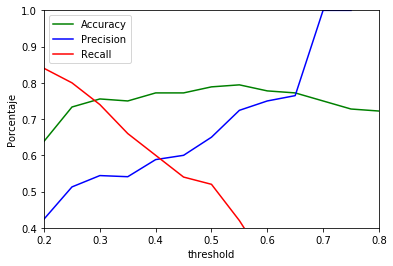

In [17]:
evaluar_modelo(X, Y, "SVM")

## 5.4. Vecinos más cercanos

Cross validation scores: 

c:\python\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in longlong_scalars


 [0.74193548 0.70967742 0.7        0.73333333 0.72413793 0.68965517]
Cross validation average score:  0.7164565566679025


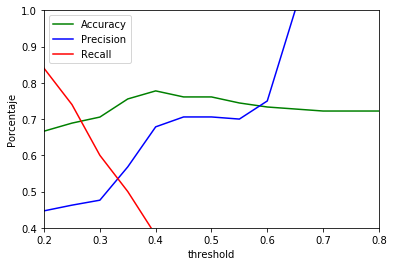

In [18]:
evaluar_modelo(X, Y, "KNN")

## 5.5. Gradient Boosting Classifier

Cross validation scores:  [0.77419355 0.70967742 0.76666667 0.7        0.75862069 0.82758621]
Cross validation average score:  0.7561240884933876


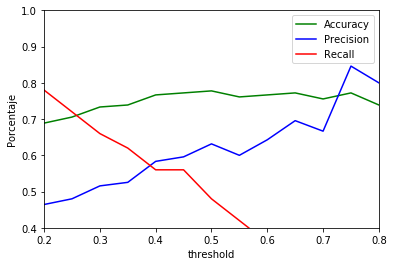

In [19]:
evaluar_modelo(X, Y, "GradientBoostingClassifier")

## 5.6. Random Forest Classifier

Cross validation scores:  [0.77419355 0.64516129 0.7        0.63333333 0.86206897 0.89655172]
Cross validation average score:  0.7518848102830304


c:\python\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in longlong_scalars


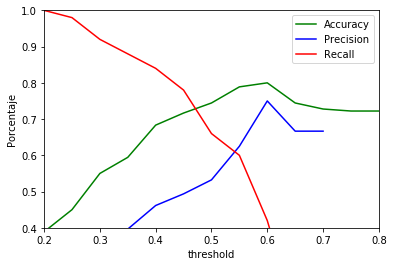

In [20]:
evaluar_modelo(X, Y, "RandomForestClassifier")

## Conclusiones
### - En general los distintos clasificadores utilizados tienen scores parecidos. Pero lo importante es como se comporta la métrica "Precision" y "Recall".
### - En base al punto anterior y las definiciones de negocio, deberíamos evaluar los distintos algoritmos con un threshold de 0.2~0.3. Haciendo esto el clasificador que mejor se ajusta es SVM con un recall de 82% y precision de %53.
### - Estos resultados no son considerados como definitivos, ya que cada algoritmo tiene distintas hiper-parámetros que pueden mejorar la solución, por lo que hay oportunidad de encontrar un clasificador que genere mejores resultados.